In [9]:
import math
import os;
import sys;

import numpy as np

sys.path.append("venv")
import pandas as pd
import datetime

In [3]:
import pandas as pd
df = pd.read_parquet('/scratch/aggregate_data/20240122_WSE.parquet', engine='pyarrow')
df

,symbol,slice,aggregate_name,value
0,RNK,2024-01-22 09:00:00,VolumeAggregate,3000.0
1,RNK,2024-01-22 09:00:00,SimpleAggregate,3000.0
2,RNK,2024-01-22 09:05:00,VolumeAggregate,69633.0
3,RNK,2024-01-22 09:05:00,SimpleAggregate,69633.0
4,OPL,2024-01-22 09:10:00,VolumeAggregate,8663.0
...,...,...,...,...
161,ALR,2024-01-22 15:40:00,SimpleAggregate,46330.0
162,OPL,2024-01-22 15:45:00,VolumeAggregate,952174.0
163,OPL,2024-01-22 15:45:00,SimpleAggregate,952174.0
164,TRK,2024-01-22 15:50:00,VolumeAggregate,1039382.0


In [ ]:
nadaq_raw_data = pd.read_parquet('../normalised_data/NASDAQ.parquet', engine='pyarrow')
wse_raw_data = pd.read_parquet('../normalised_data/WSE.parquet', engine='pyarrow') 

In [25]:
# nadaq_raw_data.query("symbol == 'AAPL'")[['timestamp', 'trade_price']]
# wse_raw_data.query("symbol == 'PKO'")



,timestamp,trade_price
1358,2024-01-22 09:00:00.128,NaN
1362,2024-01-22 09:00:00.128,NaN
1536,2024-01-22 09:00:00.130,NaN
1690,2024-01-22 09:00:00.133,NaN
2473,2024-01-22 09:00:00.200,NaN
...,...,...
259996165,2024-01-22 21:28:39.400,NaN
259996609,2024-01-22 21:28:46.874,NaN
259996610,2024-01-22 21:28:46.874,NaN
259996611,2024-01-22 21:28:46.874,193.7


In [100]:
from regionConfig.WSE import WSE
from regionConfig.NASDAQ import NASDAQ
# Spread sizes

import aggregator
import filters


class SpreadByTickSizeAggregate(aggregator.Aggregate):
    def __init__(self, region, symbol):
        self.last_bid = 0.0
        self.last_ask = 0.0
        self.region = region
        self.tick_series = []
        self.spread = 0

    def on_quote(self, quote):
        self.spread = quote.ask_price - quote.bid_price

    def on_trade(self, trade):
        tick_size = self.region.get_tick_size(trade.trade_price, trade.symbol)
        if tick_size != 0 and self.spread > 0:
            self.tick_series.append(self.spread / tick_size)

    def compute_slice(self, slice):
        if len(self.tick_series) == 0:
            return 0

        value = sum(self.tick_series) / len(self.tick_series)
        return value



agg = aggregator.Aggregator( WSE(),"20240122")
agg.registerAggregate(SpreadByTickSizeAggregate)
aggs_wse = agg.run()

# agg = aggregator.Aggregator(NASDAQ(),"20240122")
# agg.registerAggregate(SpreadByTickSizeAggregate)
# aggs_nasdaq = agg.run()

In [69]:
aggs_wse.query("slice == @eod_slice and value != 0.0")['value'].c

165      2785.714286
248      3875.968992
331       230.714286
497       247.619048
580       680.000000
            ...     
64905     437.500000
64988    1860.869565
65071     102.129630
65237    2440.000000
65320    1971.428571
Name: value, Length: 590, dtype: float64

symbol       482
slice        482
aggregate    482
value        482
dtype: int64

symbol       478
slice        478
aggregate    478
value        478
dtype: int64

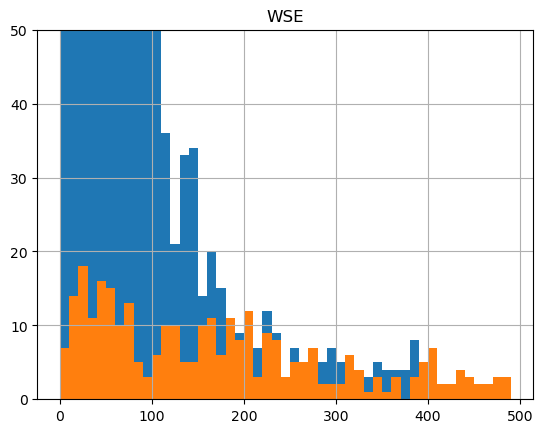

In [68]:
import datetime
import numpy
import matplotlib.pyplot as plt

eod_slice = datetime.time(15,50,00)
aggs_nasdaq.query("slice == @eod_slice and value != 0.0")['value'].clip(0,500).hist(bins=numpy.arange(start=0, stop=500, step=10, dtype=None) )
plt.ylim(0,50)
plt.title('NASDAQ')


aggs_wse.query("slice == @eod_slice and value != 0.0")['value'].clip(0,500).hist(bins=numpy.arange(start=0, stop=500, step=10, dtype=None) )
plt.ylim(0,50)
plt.title('WSE')


display(aggs_nasdaq.query("slice == @eod_slice and value != 0.0 and value > 100").count())
aggs_wse.query("slice == @eod_slice and value != 0.0 and value > 100").count()

In [88]:
aggs_nasdaq = pd.read_parquet('aggs_nasdaq', engine='pyarrow')
aggs_nasdaq

,symbol,slice,aggregate,value
0,WMPN,09:00:00,SpreadByTickSize,0.00
1,WMPN,09:05:00,SpreadByTickSize,0.00
2,WMPN,09:10:00,SpreadByTickSize,0.00
3,WMPN,09:15:00,SpreadByTickSize,0.00
4,WMPN,09:20:00,SpreadByTickSize,0.00
...,...,...,...,...
778535,HPP-C,15:30:00,SpreadByTickSize,78.25
778536,HPP-C,15:35:00,SpreadByTickSize,78.25
778537,HPP-C,15:40:00,SpreadByTickSize,78.25
778538,HPP-C,15:45:00,SpreadByTickSize,78.25


In [101]:
bin_setup = np.arange(start=0, stop=10_000, step=50).tolist()
eod_slice = datetime.time(15,50,00)
bins = pd.cut(aggs_wse.query("slice == @eod_slice and value != 0.0")['value'].clip(0,10_000), bin_setup)
aggs_wse.insert(2,'bin',bins)


In [102]:


groupe_wse = aggs_wse.groupby(['bin']).size().reset_index(name='counts')
groupe_wse['total_count'] = groupe_wse ['counts'].sum()
groupe_wse['percent_distribution'] =  groupe_wse['counts']/ groupe_wse['total_count']

display(groupe_wse)

/tmp/ipykernel_6073/1264803960.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupe_wse = aggs_wse.groupby(['bin']).size().reset_index(name='counts')


,bin,counts,total_count,percent_distribution
0,"(0, 50]",66,558,0.118280
1,"(50, 100]",46,558,0.082437
2,"(100, 150]",36,558,0.064516
3,"(150, 200]",46,558,0.082437
4,"(200, 250]",35,558,0.062724
...,...,...,...,...
194,"(9700, 9750]",0,558,0.000000
195,"(9750, 9800]",1,558,0.001792
196,"(9800, 9850]",0,558,0.000000
197,"(9850, 9900]",0,558,0.000000


In [90]:
nasdaq_bin_setup = np.arange(start=0, stop=10_000, step=50).tolist()
eod_slice = datetime.time(15,50,00)
nasdaq_bins = pd.cut(aggs_nasdaq.query("slice == @eod_slice and value != 0.0")['value'].clip(0,500), nasdaq_bin_setup)
aggs_nasdaq.insert(2,'bin',bins)

In [160]:
import math
result = []
eod_slice_aggs = aggs_nasdaq.query("slice == @eod_slice and value != 0")
for row in groupe_wse[groupe_wse["counts"] != 0].itertuples():
    aggs_in_bin = eod_slice_aggs[eod_slice_aggs['bin'] == row.bin]
    if aggs_in_bin.size != 0:
        result.extend(aggs_in_bin.sample(math.floor(row.counts), replace=True)['symbol'].tolist())

# display(result)
eod_slice_aggs = eod_slice_aggs[eod_slice_aggs['symbol'].isin(result)]
nasdaq_bins = pd.cut(eod_slice_aggs.query("slice == @eod_slice and value != 0.0")['value'].clip(0,10_000), bin_setup)
eod_slice_aggs.insert(2,'nasdaq_bin',nasdaq_bins)

eod_slice_aggs
    

,symbol,slice,nasdaq_bin,bin,aggregate,value
248,SBR,15:50:00,"(150, 200]","(450, 500]",SpreadByTickSize,151.500000
331,ATHE,15:50:00,"(0, 50]","(200, 250]",SpreadByTickSize,6.833333
497,ITW,15:50:00,"(0, 50]","(200, 250]",SpreadByTickSize,23.543814
746,MDLZ,15:50:00,"(0, 50]","(50, 100]",SpreadByTickSize,1.633762
912,OC,15:50:00,"(0, 50]","(100, 150]",SpreadByTickSize,24.889273
...,...,...,...,...,...,...
63743,AL,15:50:00,"(0, 50]","(50, 100]",SpreadByTickSize,4.146409
63992,FDX,15:50:00,"(0, 50]","(200, 250]",SpreadByTickSize,15.914920
64075,HEI,15:50:00,"(0, 50]","(150, 200]",SpreadByTickSize,26.767857
64739,SLG,15:50:00,"(0, 50]","(100, 150]",SpreadByTickSize,8.971259


Text(0.5, 1.0, 'WSE')

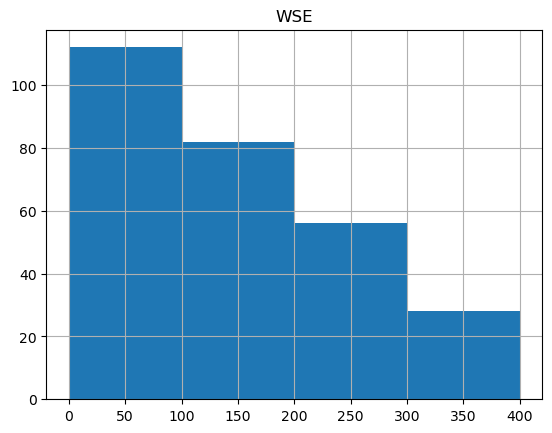

In [54]:
        s    aggs_wse.query("slice == @eod_slice and value != 0.0")['value'].clip(0,500).hist(bins=numpy.arange(start=0, stop=500, step=100, dtype=None) )
plt.ylim(0,100)
plt.title('WSE')

In [59]:
aggs_wse.query("slice == @eod_slice and value != 0.0 and value > 100").count()

symbol       478
slice        478
aggregate    478
value        478
dtype: int64

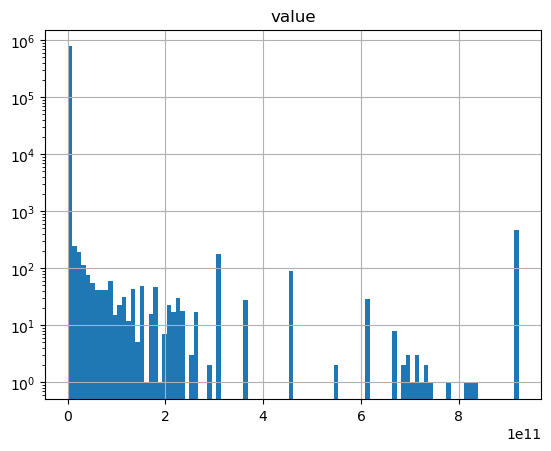

In [7]:
aggs = aggs_nasdaq
ax = aggs.hist(column='value', bins=100, log=True)

In [2]:
from regionConfig.WSE import WSE
# Spread sizes

import aggregator
import filters

class TradeCountAggregate(aggregator.Aggregate):
    def __init__(self, region, symbol):
        self.trade_count = 0

    def on_quote(self, quote):
        pass

    def on_trade(self, trade):
        self.trade_count+=1

    def compute_slice(self, slice):
        val = self.trade_count
        self.trade_count = 0 
        return val
    
class QuoteCountAggregate(aggregator.Aggregate):
    def __init__(self, region, symbol):
        self.quote_count = 0

    def on_quote(self, quote):
        self.quote_count+=1

    def on_trade(self, trade):
        pass

    def compute_slice(self, slice):
        val = self.quote_count
        self.quote_count = 0 
        return val

agg = aggregator.Aggregator(WSE(),"20240122" )
agg.registerAggregate(TradeCountAggregate)
agg.registerAggregate(QuoteCountAggregate)
trade_count_aggs = agg.run()
trade_count_aggs

,symbol,slice,aggregate,value
0,YAN,09:00:00,TradeCount,0
1,YAN,09:05:00,TradeCount,0
2,YAN,09:10:00,TradeCount,0
3,YAN,09:15:00,TradeCount,0
4,YAN,09:20:00,TradeCount,0
...,...,...,...,...
130637,ZAP,15:30:00,QuoteCount,0
130638,ZAP,15:35:00,QuoteCount,1
130639,ZAP,15:40:00,QuoteCount,2
130640,ZAP,15:45:00,QuoteCount,1


In [3]:
import pandas as pd
import datetime
first_slice_time = datetime.time(9,0,0)
trade_counts = trade_count_aggs.query('aggregate == "TradeCount"').groupby('symbol')["value"].sum()
quote_counts = trade_count_aggs.query('aggregate == "QuoteCount"').groupby('symbol')["value"].sum()
pd.DataFrame(trade_counts)

pd.merge(trade_counts, quote_counts, on='symbol', how='outer').query('value_x == 0')


,value_x,value_y
symbol,,
7FT,0,2
AAS,0,1
ABK,0,2
ADS,0,2198
AFC,0,1
...,...,...
XBS,0,3
YAN,0,10
YBS,0,2


In [9]:
import datetime
time = datetime.time(15,50,00)
aggs.query('slice == @time and value == 0')
#aggs.query('symbol == "PKO"')

,symbol,slice,aggregate,value


In [5]:
import sys
import aggregator
import filters


class volumeAggregate(aggregator.Aggregate):
    def __init__(self, region, symbol):
        self.volume = 0

    def on_quote(self, quote):
        pass

    def on_trade(self, trade):
        self.volume += trade.trade_volume

    def compute_slice(self, slice):
        ret = self.volume
        self.volume = 0
        return ret


agg = aggregator.Aggregator(WSE(), "20240122", filters.SymbolFilter('PKO'))
agg.registerAggregate(volumeAggregate)
agg.run()

,symbol,slice,aggregate,value
0,PKO,09:00:00,volume,0.0
1,PKO,09:05:00,volume,100989.0
2,PKO,09:10:00,volume,16314.0
3,PKO,09:15:00,volume,159776.0
4,PKO,09:20:00,volume,113276.0
...,...,...,...,...
78,PKO,15:30:00,volume,9423.0
79,PKO,15:35:00,volume,17653.0
80,PKO,15:40:00,volume,16664.0
81,PKO,15:45:00,volume,23848.0
